In [34]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install scikit-learn

     |████████████████████████████████| 11.1 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 57.8 MB/s eta 0:00:01


In [1]:
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re

In [2]:
def extract_slurm_jobs(start_id, end_id, slurm_df, input_size_dict, output_size_dict):
    
    header=["job_id", 
                "job_name", 
                "total_cpu", 
                "ave_rss_mb", 
                "ave_vmz_mb", 
                "alloc_cpu", 
                "alloc_mem_gb", 
                "ave_read_kb", 
                "ave_write_kb", 
                "elapsed_sec", 
                "cpu_effic",
                "cpu_usage",
                "state",  
                "srr_id"]
    fields = ['JobID',
              'JobName',
              'TotalCPU',
              'AveRSS',
              'AveVMSize',
              'AllocTRES',
              'AveDiskRead',
              'AveDiskWrite',
              'Elapsed',
              'State',
              'SubmitLine']
    ext_data = []
    
    for job_id in range(start_id, end_id+1):
        job_id_batch = str(job_id) + ".batch"
        
        #print(fields)
        values=df[fields][df["JobID"]==str(job_id)].values[0]
        values_batch=df[fields][df["JobID"]==job_id_batch].values[0]
        
        #print(len(values), values)
        datum = []
        
        job_id = values[0]
        job_name = values[1]
        

     
        if(len(values_batch[2].split(":")) == 2):
            total_cpu = datetime.strptime(values_batch[2],'%M:%S.%f')
            total_cpu = total_cpu.second + total_cpu.minute*60 + (total_cpu.microsecond / 1000000)
        else:
            total_cpu = datetime.strptime(values_batch[2],'%H:%M:%S')
            total_cpu = total_cpu.second + total_cpu.minute*60 + total_cpu.hour*3600
            
        
        
        ave_rss = values_batch[3]
        if ave_rss == "0":
            ave_rss = float(ave_rss)
        else:
            ave_rss = float(ave_rss[:-1])
        
        ave_vmz = values_batch[4]
        if ave_vmz == "0":
            ave_vmz = float(ave_vmz)
        else:
            ave_vmz = float(ave_vmz[:-1])
        
        alloc_tres = values_batch[5].split(",")
        alloc_cpu = int(alloc_tres[0].split("=")[1])
        alloc_mem = int(alloc_tres[1].split("=")[1][0:-1])
        
        ave_read = values_batch[6]
        if ave_read == "0":
            ave_read = float(ave_read)
        else:
            ave_read = float(ave_read[:-1])
            
        ave_write = values_batch[7]
        if ave_write == "0":
            ave_write = float(ave_write)
        else:
            ave_write = float(ave_write[:-1])
            
        
        
        elapsed = datetime.strptime(values_batch[8],'%H:%M:%S')
        elapsed = elapsed.second + elapsed.minute*60 + elapsed.hour*3600
        
        cpu_effic = (total_cpu / (elapsed * alloc_cpu)) * 100
        cpu_usage = alloc_cpu * (cpu_effic/100)
        
        state = values[9]
        submit_line = values[10].split(" ")
        
        #print(submit_line)
        srr_id = submit_line[-1]
        
        input_size = input_size_dict[srr_id]
        output_size = output_size_dict[srr_id]
        
        datum = [job_id,
                   job_name,
                   total_cpu,
                   ave_rss,
                   ave_vmz,
                   alloc_cpu,
                   alloc_mem,
                   ave_read,
                   ave_write,
                   elapsed,
                   cpu_effic,
                   cpu_usage,
                   state,
                   srr_id]
        
        ext_data.append(datum)

    ext_df = pd.DataFrame(ext_data, columns=header)
    return ext_df

def load_sacct_job_dataframe(path):
    fields = "Account|AdminComment|AllocCPUS|AllocNodes|AllocTRES|AssocID|AveCPU|AveCPUFreq|AveDiskRead|AveDiskWrite|AvePages|AveRSS|AveVMSize|BlockID|Cluster|Comment|Constraints|ConsumedEnergy|ConsumedEnergyRaw|Container|CPUTime|CPUTimeRAW|DBIndex|DerivedExitCode|Elapsed|ElapsedRaw|Eligible|End|ExitCode|Flags|GID|Group|JobID|JobIDRaw|JobName|Layout|MaxDiskRead|MaxDiskReadNode|MaxDiskReadTask|MaxDiskWrite|MaxDiskWriteNode|MaxDiskWriteTask|MaxPages|MaxPagesNode|MaxPagesTask|MaxRSS|MaxRSSNode|MaxRSSTask|MaxVMSize|MaxVMSizeNode|MaxVMSizeTask|McsLabel|MinCPU|MinCPUNode|MinCPUTask|NCPUS|NNodes|NodeList|NTasks|Partition|Priority|QOS|QOSRAW|Reason|ReqCPUFreq|ReqCPUFreqGov|ReqCPUFreqMax|ReqCPUFreqMin|ReqCPUS|ReqMem|ReqNodes|ReqTRES|Reservation|ReservationId|Reserved|ResvCPU|ResvCPURAW|Start|State|Submit|SubmitLine|Suspended|SystemComment|SystemCPU|Timelimit|TimelimitRaw|TotalCPU|TRESUsageInAve|TRESUsageInMax|TRESUsageInMaxNode|TRESUsageInMaxTask|TRESUsageInMin|TRESUsageInMinNode|TRESUsageInMinTask|TRESUsageInTot|TRESUsageOutAve|TRESUsageOutMax|TRESUsageOutMaxNode|TRESUsageOutMaxTask|TRESUsageOutMin|TRESUsageOutMinNode|TRESUsageOutMinTask|TRESUsageOutTot|UID|User|UserCPU|WCKey|WCKeyID|WorkDir"
    fields = fields.split("|")
    df = pd.read_csv(path, sep="|", names=fields)
    return df

def get_file_size_dict(file_path):

    # SIZE IN BYTES
    
    files = open(file_path, "r")

    # reading the file
    data = files.read()

    data_into_list = [i for i in data.split("\n")[1:] if i != '']
    size_dict = dict()
    for data in data_into_list:
        splitted_data = re.split('\s+', data)
        #print(splitted_data)
        size = splitted_data[4]
        srr_id = splitted_data[-1].split(".")[0]
        size_dict[srr_id] = int(size)
    
    files.close()
    return size_dict

def generate_comprehensive_dataframe(path):
    comp_data = []
    stats_df_list = []
    header = ["job_id", "job_name", "alloc_cpu", "alloc_mem_gb", "elapsed_sec", "state", "sra_id", "input_size", "output_size"]
    
    input_size_dict = get_file_size_dict(f"{path}/file_size/input_files.txt")
    output_size_dict = get_file_size_dict(f"{path}/file_size/output_files.txt")
    
    sacct_df = load_sacct_job_dataframe(f"{path}/stats/sacct.txt")
    fields = ["JobID", "JobName", "AllocTRES", "Elapsed", "State", "SubmitLine"]
    job_ids = [int(i) for i in sacct_df["JobID"].values if "batch" not in i]
    for job_id in job_ids:
        job_id_batch = str(job_id) + ".batch"
        values=sacct_df[fields][sacct_df["JobID"]==str(job_id)].values[0]
        values_batch=sacct_df[fields][sacct_df["JobID"]==job_id_batch].values[0]

        job_id = int(values[0])
        job_name = values[1]
        
        alloc_tres = values_batch[2].split(",")
        alloc_cpu = int(alloc_tres[0].split("=")[1])
        alloc_mem = int(alloc_tres[1].split("=")[1][0:-1])

        elapsed = datetime.strptime(values_batch[3],'%H:%M:%S')
        elapsed = elapsed.second + elapsed.minute*60 + elapsed.hour*3600

        state = values[4]
        submit_line = values[5].split(" ")
        
        srr_id = submit_line[-1]

        input_size = input_size_dict[srr_id]
        output_size = output_size_dict[srr_id]
        
        datum = [job_id,
           job_name,
           alloc_cpu,
           alloc_mem,
           elapsed,
           state,
           srr_id,
           input_size,
           output_size]
        comp_data.append(datum)
        
        stats_df = load_stat_dataframe_of_job(path, job_id)
     
        if stats_df is not None:
            stats_df_list.append(stats_df)
        
    stats_df = pd.concat(stats_df_list, ignore_index=True, axis=0)
    comp_df = pd.DataFrame(comp_data, columns=header)
    comp_df = pd.merge(comp_df, stats_df, on='job_id', how='outer')
    
    return comp_df
    
def load_stat_dataframe_of_job(dir, job_id):
    from pandas.errors import EmptyDataError 
    
    stats_df = None
    
    try:
        stats_df = pd.read_csv(f"{dir}/stats/{job_id}_stat.csv")
        stats_df = stats_df.astype({"job_id": int, "pid": int, "cpu": float, "vsz_bytes": int, "rss_bytes": int, "read_bytes": int, "write_bytes": int})
    except (FileNotFoundError, EmptyDataError):
        pass
        
        
    return stats_df    

def drop_null_data(df):
    print("SIZE BEFORE DROPPING:", df.shape)
    dfresult = df.dropna()
    print("SIZE BEFORE DROPPING:", dfresult.shape)
    print(f"DROP {df.shape[0] - dfresult.shape[0]} rows") 
    return dfresult

def summarize_dataframe(df):
    df = df.drop(['timestamp'], axis=1)
    header = ["job_id", "job_name", 'alloc_cpu', 'alloc_mem_gb', 'elapsed_sec', 'state', 'sra_id', 'input_size', 'output_size', 'pid', "n_pack", "pack_id", "ave_cpu", "peak_cpu", "ave_vsz", "peak_vsz", "ave_rss", "peak_rss","read_bytes","write_bytes"]
    sum_data = []
    
    job_ids = df["job_id"].unique()

    for j_id in job_ids:
        stats = df[df["job_id"] == j_id]

        job_id = stats["job_id"].iloc[0]
        job_name = stats["job_name"].iloc[0]
        alloc_cpu = stats["alloc_cpu"].iloc[0]
        alloc_mem = stats["alloc_mem_gb"].iloc[0]
        elapsed_sec = stats["elapsed_sec"].iloc[0]
        state = stats["state"].iloc[0]

        sra_id = stats["sra_id"].iloc[0]
        input_size = stats["input_size"].iloc[0]
        output_size = stats["output_size"].iloc[0]
        pid = stats["pid"].iloc[0]
        n_pack = stats["n_pack"].iloc[0]
        pack_id = stats["pack_id"].iloc[0]
        
        ave_cpu = stats["cpu"].mean()
        peak_cpu = stats["cpu"].max()
        
        ave_vsz = stats["vsz_bytes"].mean()
        peak_vsz = stats["vsz_bytes"].max()

        ave_rss = stats["rss_bytes"].mean()
        peak_rss = stats["rss_bytes"].max()
        
        read = stats["read_bytes"].max()
        write = stats["write_bytes"].max()

        datum = [
            job_id,
            job_name,
            alloc_cpu,
            alloc_mem,
            elapsed_sec,
            state,
            sra_id,
            input_size,
            output_size,
            pid,
            n_pack,
            pack_id,
            ave_cpu,
            peak_cpu,
            ave_vsz,
            peak_vsz,
            ave_rss,
            peak_rss,
            read,
            write
        ]
        sum_data.append(datum)

    sum_df = pd.DataFrame(sum_data, columns=header)
    
    # df = df.groupby(['job_id', 'job_name', 'alloc_cpu', 'alloc_mem_gb', 'elapsed_sec', 'state', 'threads', 'sra_id', 'input_size', 'output_size', 'pid', "n_pack", "pack_id"]).mean()
    return sum_df

In [3]:
def save_comprehensive_dataframe(df, path, filename):
    df.to_csv(f'{path}/{filename}.csv', index=False)
    

In [4]:
DIR = "/home/cc/research/samtool_2"
DIR = "./"
comp_df = generate_comprehensive_dataframe(DIR)

In [5]:
comp_df

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,sra_id,input_size,output_size,timestamp,pid,n_pack,pack_id,cpu,vsz_bytes,rss_bytes,read_bytes,write_bytes
0,17695,samtool.sh,16,64,10,COMPLETED,SRR2059426,515558575,40870741,2023-07-31 08:30:56,229997.0,2,423,93.3333,8056832.0,4509696.0,164560896.0,12582912.0
1,17695,samtool.sh,16,64,10,COMPLETED,SRR2059426,515558575,40870741,2023-07-31 08:30:57,229997.0,2,423,90.0000,8056832.0,4509696.0,199888896.0,16777216.0
2,17695,samtool.sh,16,64,10,COMPLETED,SRR2059426,515558575,40870741,2023-07-31 08:30:58,229997.0,2,423,92.0000,8056832.0,4509696.0,240144384.0,19922944.0
3,17695,samtool.sh,16,64,10,COMPLETED,SRR2059426,515558575,40870741,2023-07-31 08:30:59,229997.0,2,423,91.0000,8056832.0,4509696.0,276799488.0,24117248.0
4,17695,samtool.sh,16,64,10,COMPLETED,SRR2059426,515558575,40870741,2023-07-31 08:31:00,229997.0,2,423,91.0000,8056832.0,4509696.0,312643584.0,26214400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45958,17364,samtool.sh,8,16,15,COMPLETED,SRR2059429,377159581,81492736,2023-07-31 08:07:25,239128.0,3,282,98.0198,8056832.0,4751360.0,267386880.0,56623104.0
45959,17364,samtool.sh,8,16,15,COMPLETED,SRR2059429,377159581,81492736,2023-07-31 08:07:26,239128.0,3,282,101.0000,8056832.0,4751360.0,298319872.0,63963136.0
45960,17364,samtool.sh,8,16,15,COMPLETED,SRR2059429,377159581,81492736,2023-07-31 08:07:27,239128.0,3,282,100.0000,8056832.0,4751360.0,329121792.0,70254592.0
45961,17364,samtool.sh,8,16,15,COMPLETED,SRR2059429,377159581,81492736,2023-07-31 08:07:28,239128.0,3,282,100.0000,8056832.0,4751360.0,360710144.0,77594624.0


In [6]:
# CHECK NULL DATA
comp_df[comp_df.isna().any(axis=1)]

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,sra_id,input_size,output_size,timestamp,pid,n_pack,pack_id,cpu,vsz_bytes,rss_bytes,read_bytes,write_bytes
26847,17226,samtool.sh,32,16,27,COMPLETED,SRR2059432,684927418,145832101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29662,17224,samtool.sh,2,64,28,COMPLETED,SRR2059432,684927418,145832101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33052,18395,samtool.sh,16,16,17,COMPLETED,SRR2059431,423971215,91545335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44550,17225,samtool.sh,8,8,28,COMPLETED,SRR2059432,684927418,145832101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45963 entries, 0 to 45962
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job_id        45963 non-null  int64  
 1   job_name      45963 non-null  object 
 2   alloc_cpu     45963 non-null  int64  
 3   alloc_mem_gb  45963 non-null  int64  
 4   elapsed_sec   45963 non-null  int64  
 5   state         45963 non-null  object 
 6   sra_id        45963 non-null  object 
 7   input_size    45963 non-null  int64  
 8   output_size   45963 non-null  int64  
 9   timestamp     45959 non-null  object 
 10  pid           45959 non-null  float64
 11  n_pack        45959 non-null  object 
 12  pack_id       45959 non-null  object 
 13  cpu           45959 non-null  float64
 14  vsz_bytes     45959 non-null  float64
 15  rss_bytes     45959 non-null  float64
 16  read_bytes    45959 non-null  float64
 17  write_bytes   45959 non-null  float64
dtypes: float64(6), int64(6), o

In [8]:
# DROP NULL DATA 
comp_df = drop_null_data(comp_df)

SIZE BEFORE DROPPING: (45963, 18)
SIZE BEFORE DROPPING: (45959, 18)
DROP 4 rows


In [9]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45959 entries, 0 to 45962
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job_id        45959 non-null  int64  
 1   job_name      45959 non-null  object 
 2   alloc_cpu     45959 non-null  int64  
 3   alloc_mem_gb  45959 non-null  int64  
 4   elapsed_sec   45959 non-null  int64  
 5   state         45959 non-null  object 
 6   sra_id        45959 non-null  object 
 7   input_size    45959 non-null  int64  
 8   output_size   45959 non-null  int64  
 9   timestamp     45959 non-null  object 
 10  pid           45959 non-null  float64
 11  n_pack        45959 non-null  object 
 12  pack_id       45959 non-null  object 
 13  cpu           45959 non-null  float64
 14  vsz_bytes     45959 non-null  float64
 15  rss_bytes     45959 non-null  float64
 16  read_bytes    45959 non-null  float64
 17  write_bytes   45959 non-null  float64
dtypes: float64(6), int64(6), o

In [10]:
comp_df = comp_df.astype({"job_id": int, "pid": int, "n_pack": int, "cpu": float, "vsz_bytes": int, "rss_bytes": int, "read_bytes": int, "write_bytes": int})

In [11]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45959 entries, 0 to 45962
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job_id        45959 non-null  int64  
 1   job_name      45959 non-null  object 
 2   alloc_cpu     45959 non-null  int64  
 3   alloc_mem_gb  45959 non-null  int64  
 4   elapsed_sec   45959 non-null  int64  
 5   state         45959 non-null  object 
 6   sra_id        45959 non-null  object 
 7   input_size    45959 non-null  int64  
 8   output_size   45959 non-null  int64  
 9   timestamp     45959 non-null  object 
 10  pid           45959 non-null  int64  
 11  n_pack        45959 non-null  int64  
 12  pack_id       45959 non-null  object 
 13  cpu           45959 non-null  float64
 14  vsz_bytes     45959 non-null  int64  
 15  rss_bytes     45959 non-null  int64  
 16  read_bytes    45959 non-null  int64  
 17  write_bytes   45959 non-null  int64  
dtypes: float64(1), int64(12), 

In [12]:
sum_df = summarize_dataframe(comp_df)

In [13]:
sum_df

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,sra_id,input_size,output_size,pid,n_pack,pack_id,ave_cpu,peak_cpu,ave_vsz,peak_vsz,ave_rss,peak_rss,read_bytes,write_bytes
0,17695,samtool.sh,16,64,10,COMPLETED,SRR2059426,515558575,40870741,229997,2,423,89.222217,93.3333,8.033621e+06,8056832,4509696.0,4509696,338612224,30388224
1,17196,samtool.sh,8,16,28,COMPLETED,SRR2059431,423971215,91545335,234607,2,211,66.243173,101.0000,8.006191e+06,8056832,4829184.0,4829184,25489408,9437184
2,17003,samtool.sh,2,8,26,COMPLETED,SRR2059431,423971215,91545335,232734,3,128,57.948637,101.0000,7.993003e+06,8056832,4624384.0,4624384,29229056,6291456
3,17184,samtool.sh,2,8,52,COMPLETED,SRR2059430,694113996,144503120,165565,3,207,43.235331,100.0000,7.969792e+06,8056832,4636672.0,4636672,218107904,43843584
4,17311,samtool.sh,32,64,8,COMPLETED,SRR2059426,515558575,40870741,225923,1,261,99.335740,101.0000,8.001126e+06,8056832,4595712.0,4595712,482508800,37748736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,17931,samtool.sh,2,32,39,COMPLETED,SRR2059427,625008228,138674865,167344,2,522,62.584926,101.0000,7.995392e+06,8056832,4804608.0,4804608,598466560,134483968
1992,17205,samtool.sh,32,32,20,COMPLETED,SRR2059431,423971215,91545335,233614,2,215,67.597419,101.0000,7.995904e+06,8056832,4620288.0,4620288,392503296,86302720
1993,18265,samtool.sh,32,64,30,COMPLETED,SRR2059434,842951902,179196758,233984,1,663,94.803592,101.0000,8.040120e+06,8056832,4698112.0,4698112,842657792,179200000
1994,17552,samtool.sh,2,64,36,COMPLETED,SRR2059429,377159581,81492736,226385,2,361,41.509180,100.0000,7.973274e+06,8056832,4849664.0,4849664,311275520,69959680


## Analysis

In [99]:
completed_df = sum_df[sum_df["state"]=="COMPLETED"]

In [15]:
from scipy.stats.stats import pearsonr

def calculate_correlation(df, features, target):
    
    corr_dict = dict()
    y = df[target]
    for col in features:
        
        x = df[col]
        corr, _ =  pearsonr(x, y)
        corr_dict[col] = corr
    
  
    corr_df = pd.Series(corr_dict)
    corr_df.index = features
    corr_df.sort_values(ascending=False).plot.bar(figsize=(20, 8))
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda x:np.abs(x[1]), reverse=True))
    
    return sorted_corr_dict


/tmp/ipykernel_164840/616510216.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


{'output_size': 0.7630770904342206,
 'input_size': 0.6512403987287787,
 'ave_cpu': -0.5669988471284422,
 'ave_vsz': -0.3485164350964347,
 'write_bytes': 0.18961261203225646,
 'peak_cpu': 0.17397007848668192,
 'n_pack': 0.14569136913049818,
 'read_bytes': 0.10902639554269405,
 'alloc_cpu': -0.09546562726024473,
 'peak_vsz': 0.07442661729197601,
 'peak_rss': 0.04622111025390065,
 'alloc_mem_gb': -0.03842146229093942,
 'ave_rss': 0.03432687028476695}

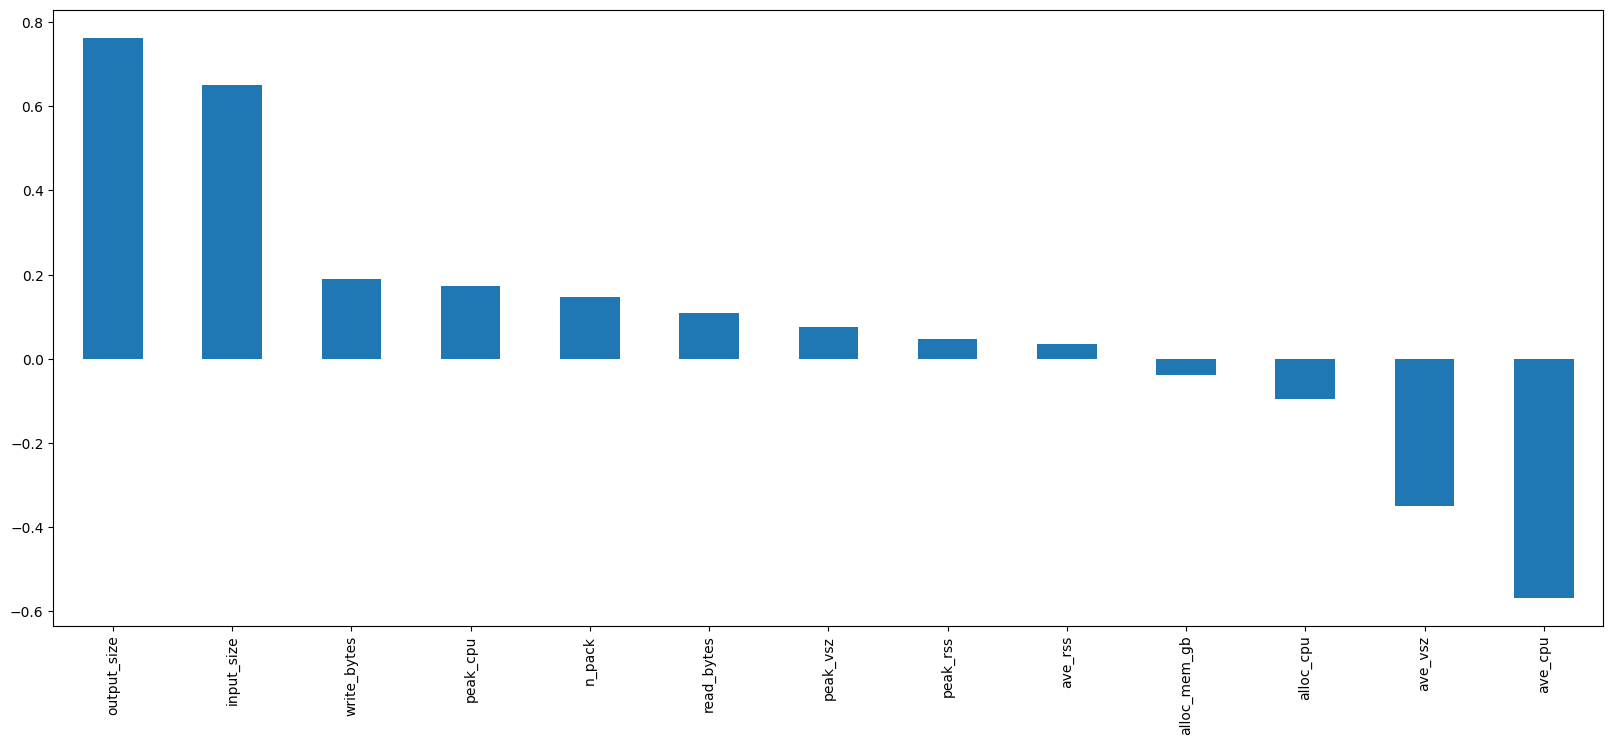

In [16]:
features =  ["alloc_cpu", "alloc_mem_gb", "input_size", "output_size", "n_pack", "ave_cpu", "peak_cpu", "ave_vsz", "peak_vsz", "ave_rss", "peak_rss", "read_bytes", "write_bytes"]
target = "elapsed_sec"
calculate_correlation(sum_df, features, target)

In [26]:
completed_df["sra_id"].unique()

array(['SRR2059426', 'SRR2059431', 'SRR2059430', 'SRR1658393',
       'SRR2059429', 'SRR2059433', 'SRR2059434', 'SRR2059432',
       'SRR2059428', 'SRR2059427'], dtype=object)

### Pre-execution Features

Text(0.5, 0.0, 'Number of Allocated CPU')

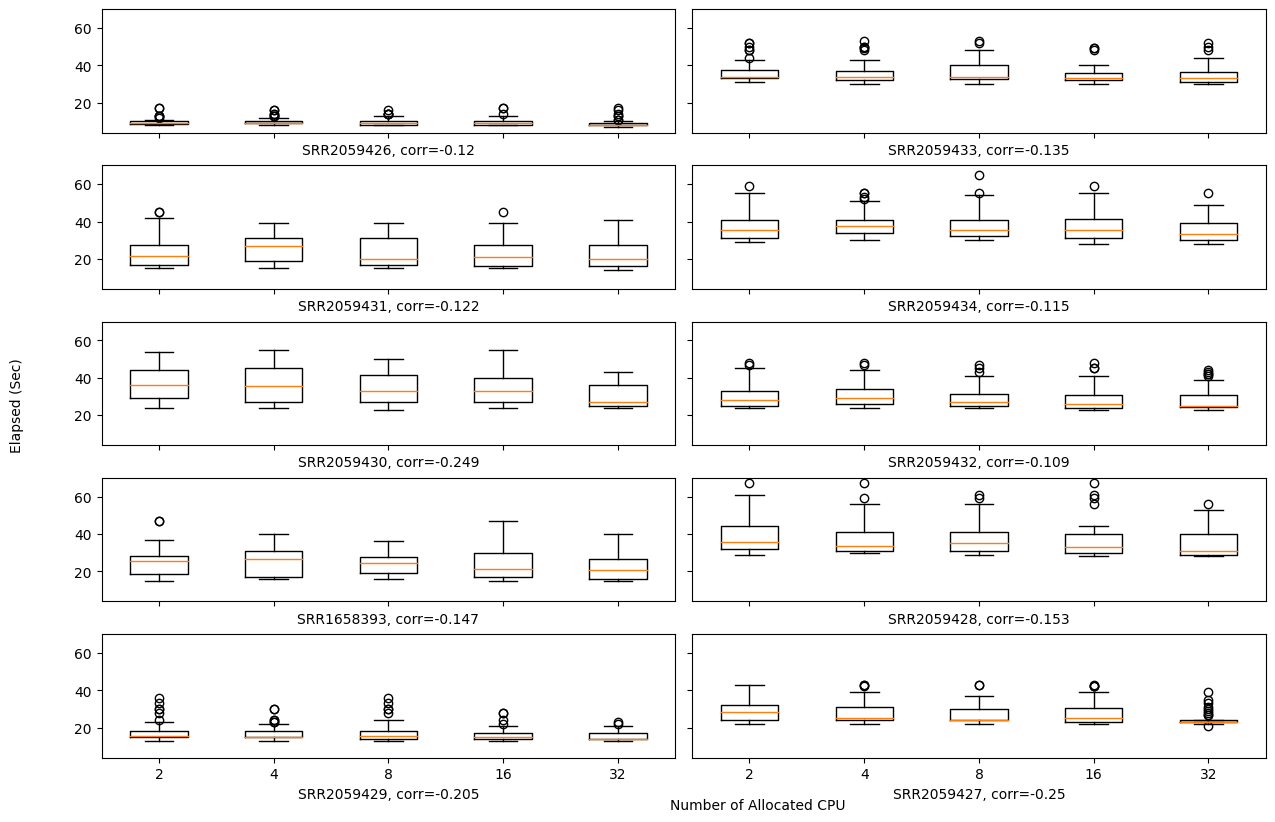

In [27]:
target = "alloc_cpu"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Number of Allocated CPU', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Number of Allocated Memory (GB)')

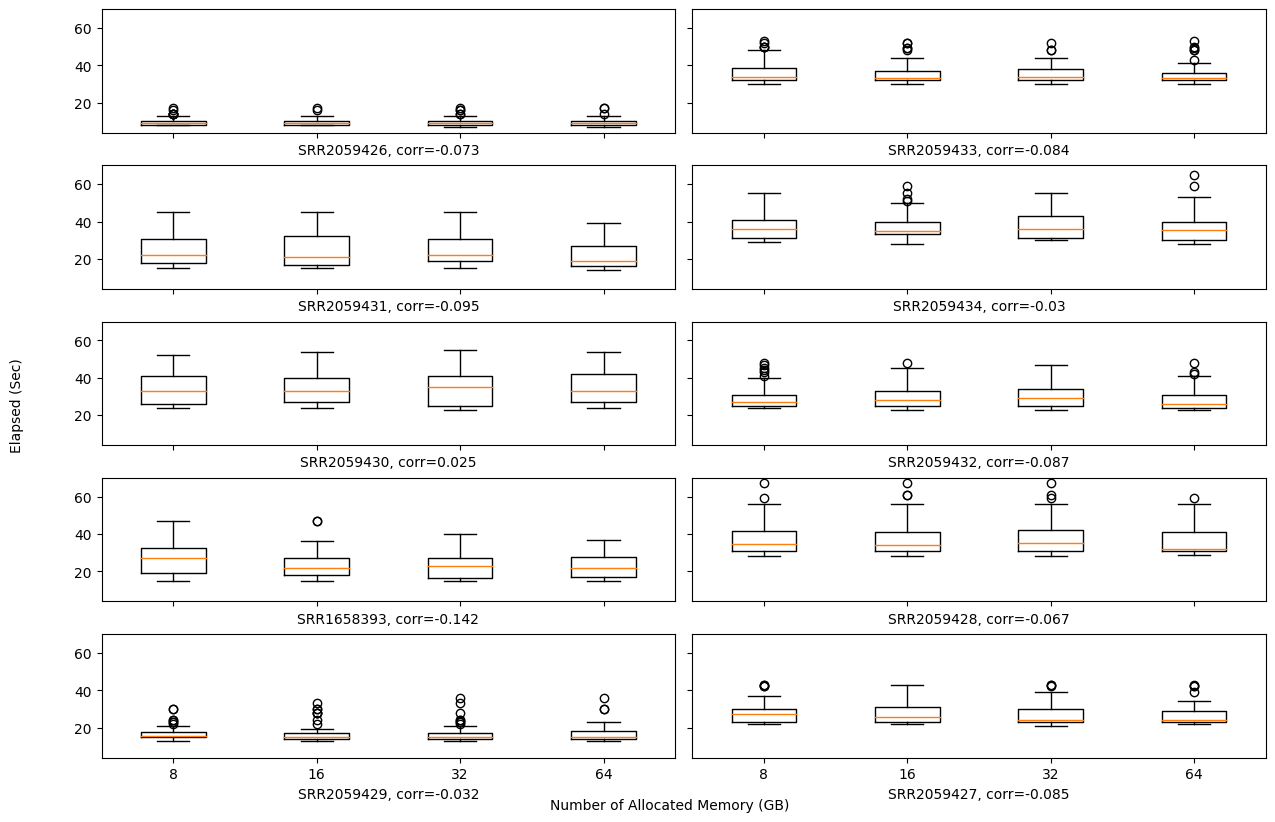

In [70]:
target = "alloc_mem_gb"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Number of Allocated Memory (GB)', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

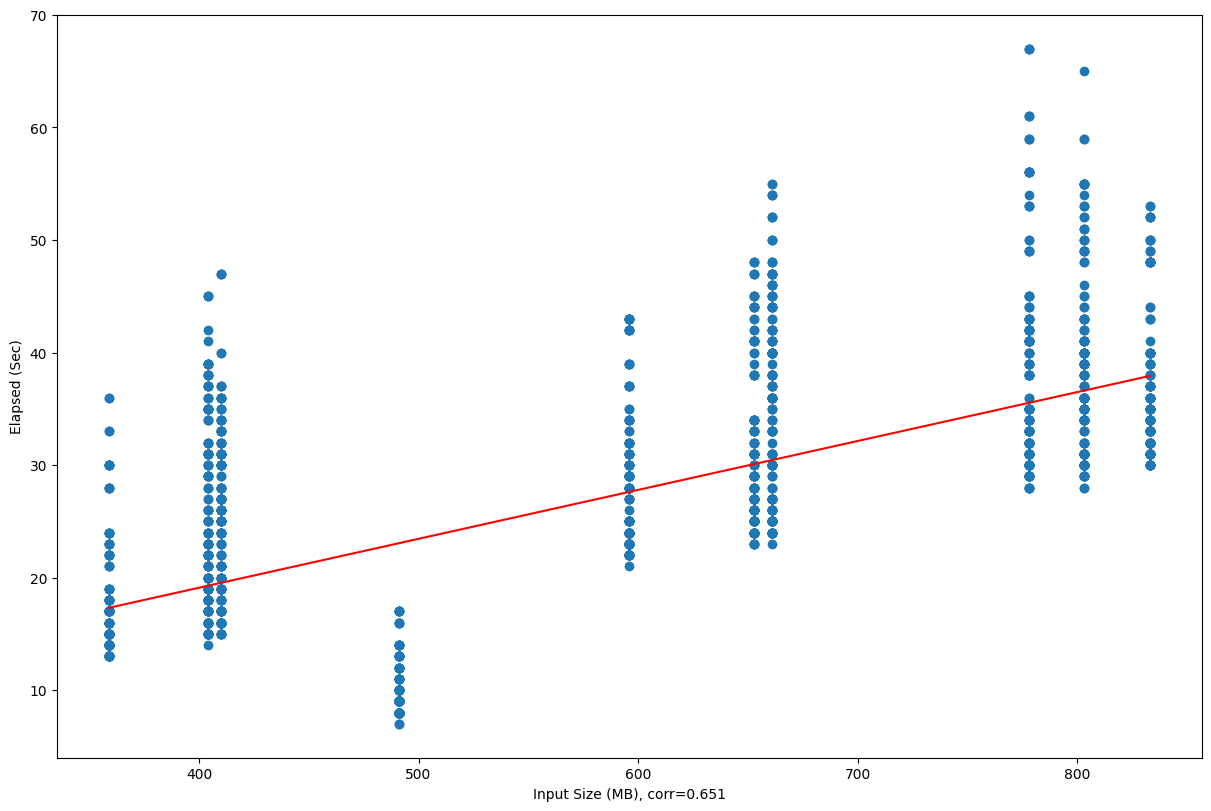

In [23]:
target = "input_size"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2) # B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Input Size (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

### Post-execution Features

Text(0.5, 0.0, 'Average CPU Usage (%)')

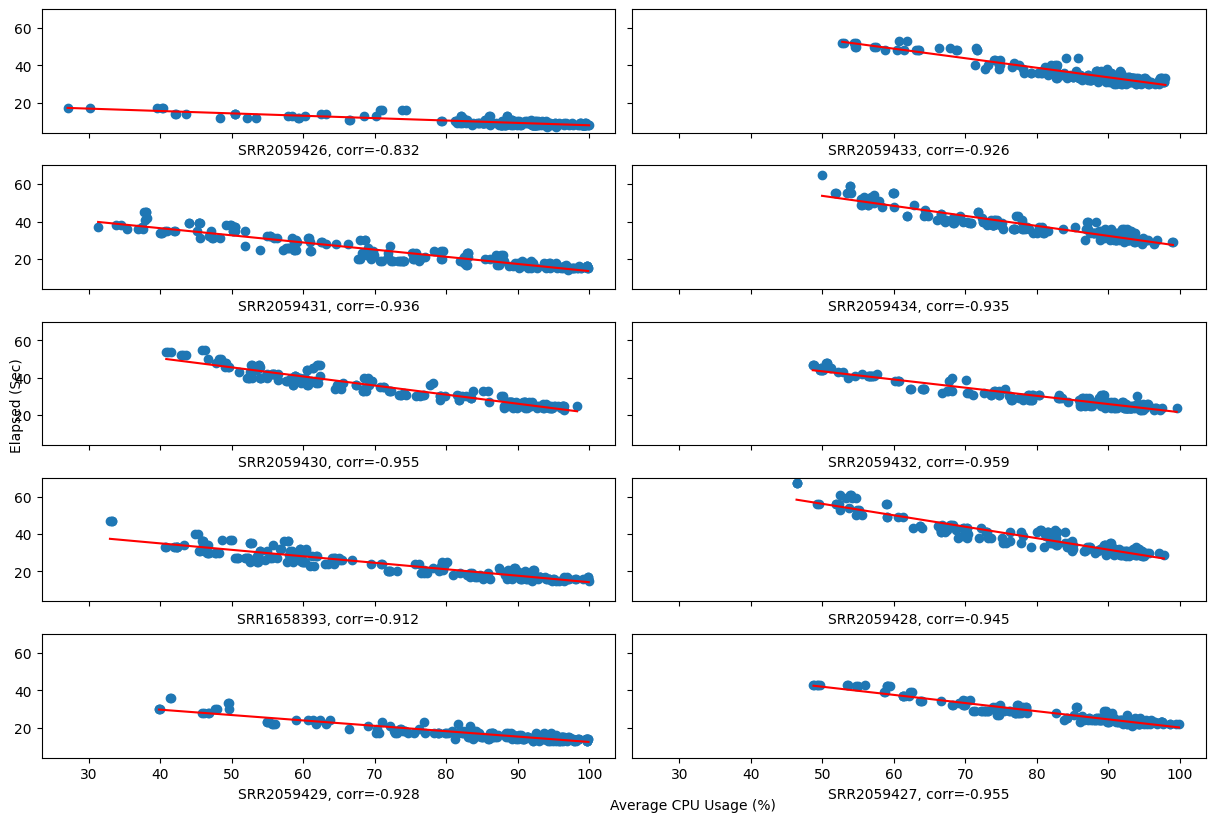

In [24]:
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df["ave_cpu"]
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Average CPU Usage (%)', va='center', rotation='horizontal')

Text(0.5, 0.0, 'Peak CPU Usage (%)')

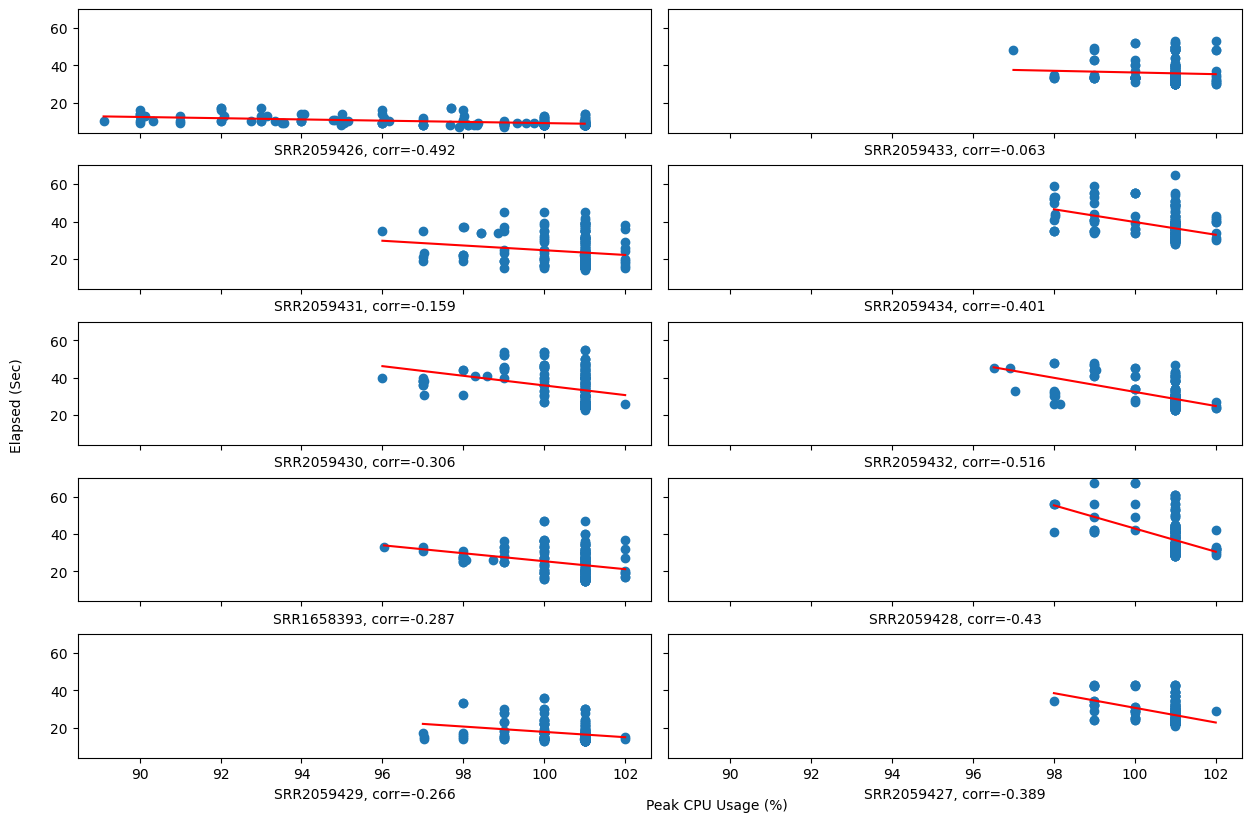

In [18]:
target = "peak_cpu"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Peak CPU Usage (%)', va='center', rotation='horizontal')

In [25]:
comp_df[["job_id", "cpu"]]

,job_id,cpu
0,17695,93.3333
1,17695,90.0000
2,17695,92.0000
3,17695,91.0000
4,17695,91.0000
...,...,...
45958,17364,98.0198
45959,17364,101.0000
45960,17364,100.0000
45961,17364,100.0000


Text(0.4, 0.0, 'Average Physical Memory Usage (KB)')

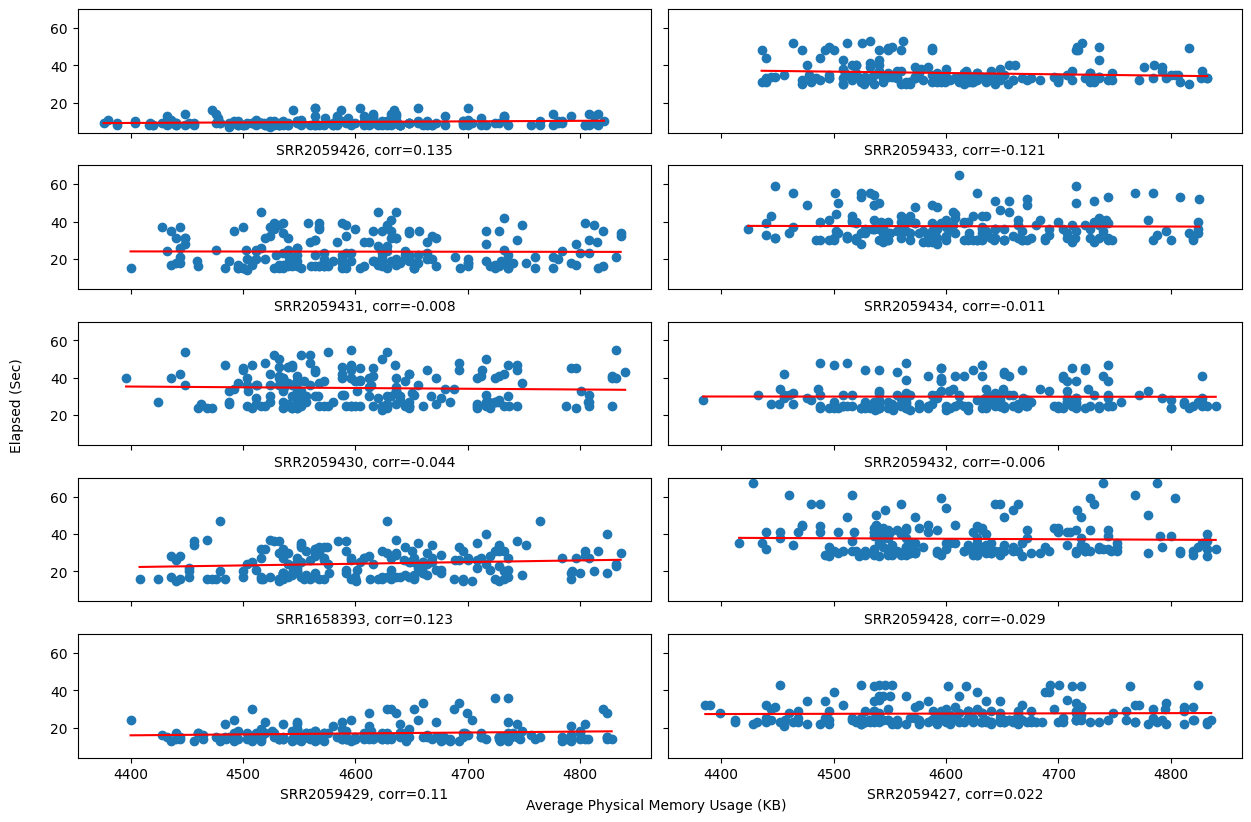

In [34]:
target = "ave_rss"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Average Physical Memory Usage (KB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Peak Physical Memory Usage (KB)')

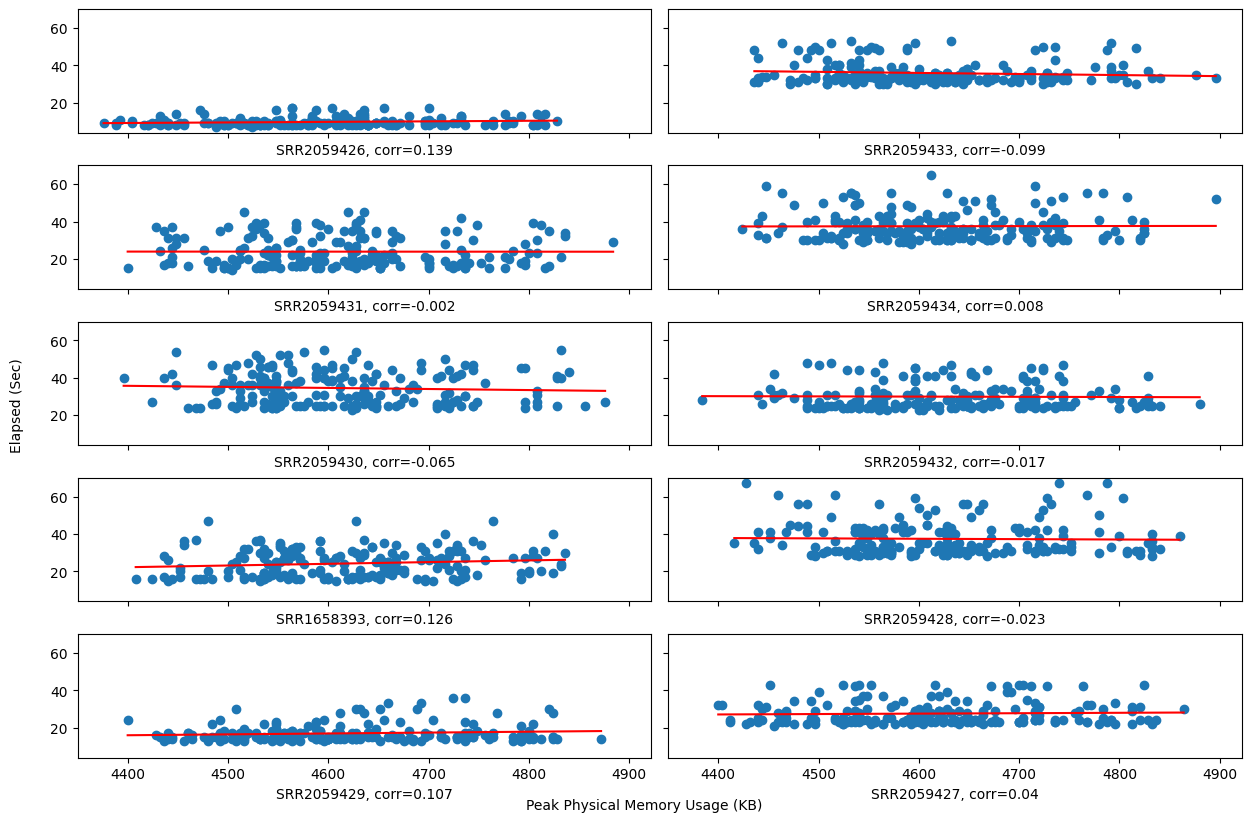

In [35]:
target = "peak_rss"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Peak Physical Memory Usage (KB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Average Virtual Memory Size (KB)')

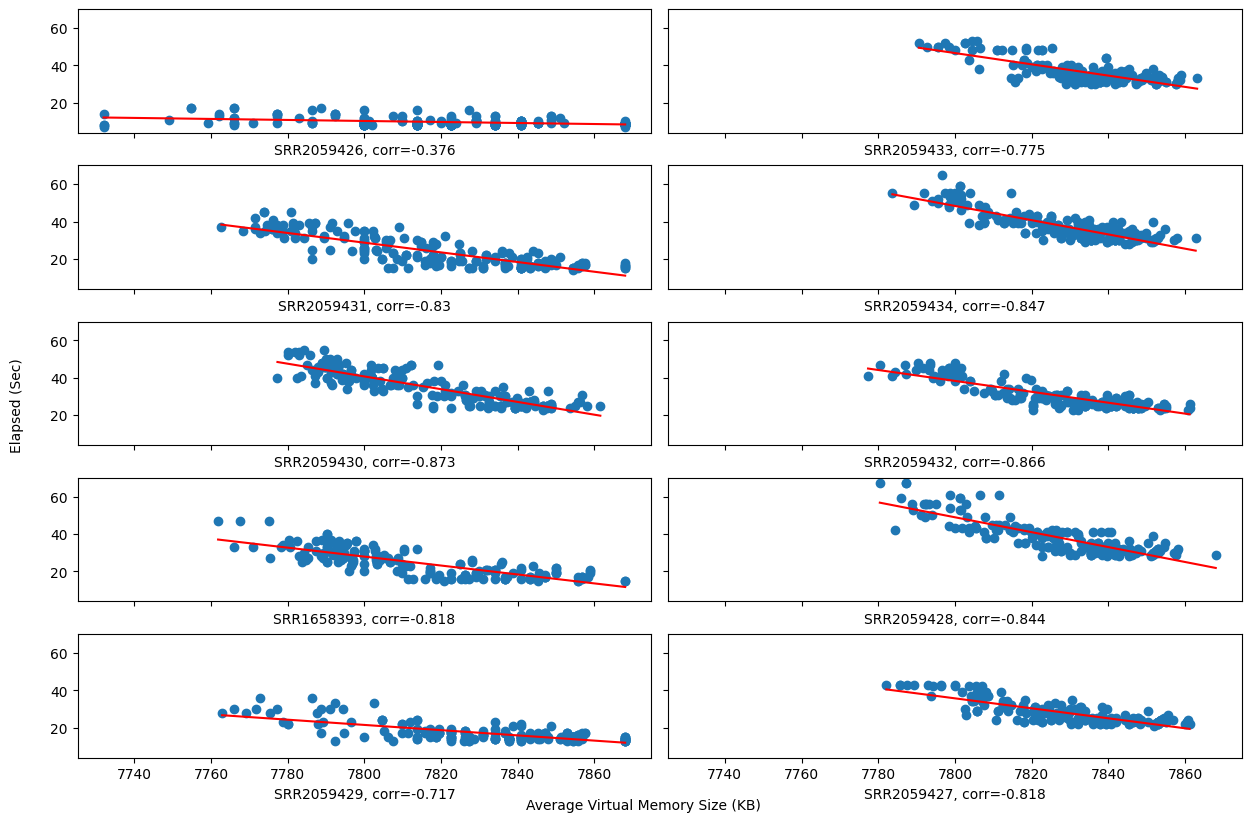

In [36]:
target = "ave_vsz"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Average Virtual Memory Size (KB)', va='center', rotation='horizontal')

In [40]:
completed_df[target].isna().any()

False

/home/cc/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/cc/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cc/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/cc/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/cc/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/cc/.local/lib/python3.8/site-packages/IPython/co

Text(0.4, 0.0, 'Peak Virtual Memory Size (KB)')

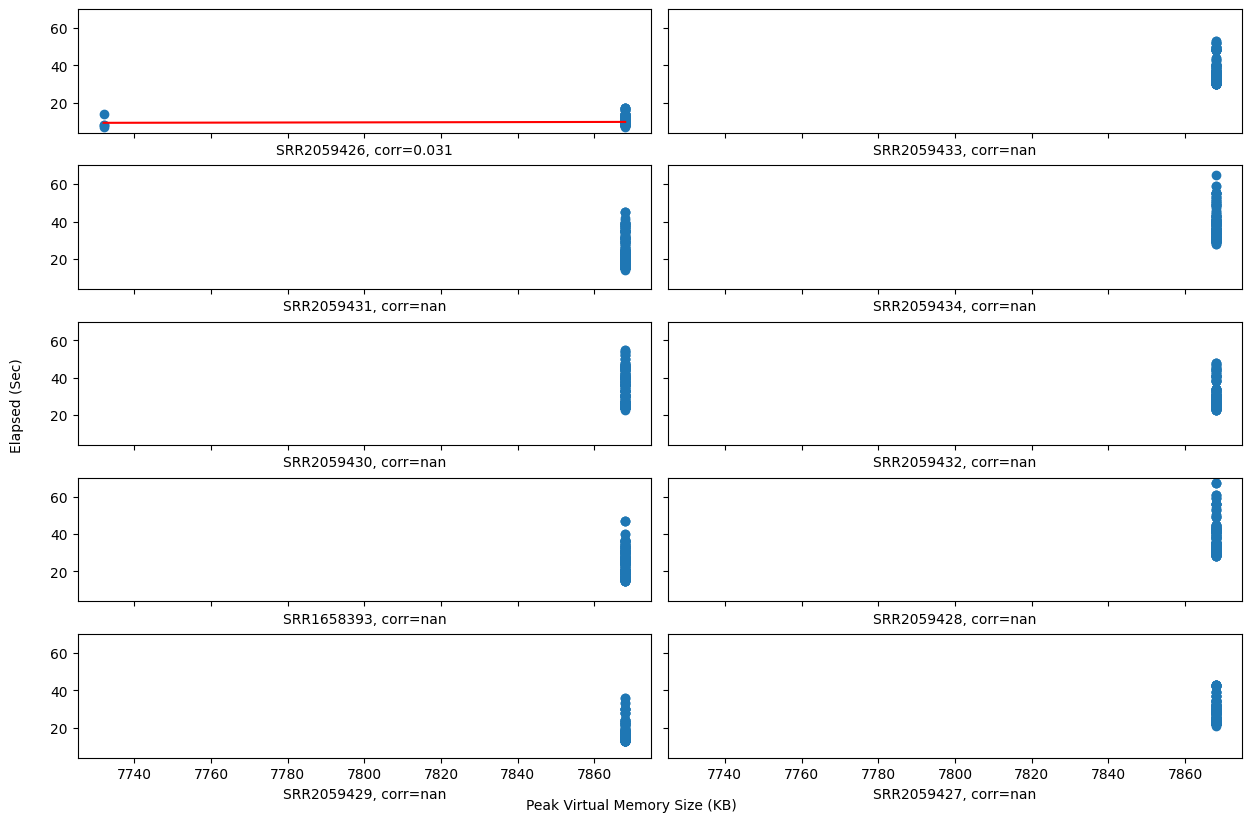

In [26]:
target = "peak_vsz"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Peak Virtual Memory Size (KB)', va='center', rotation='horizontal')

In [27]:
completed_df["peak_vsz"].unique()

array([8056832, 7917568])

Text(0.4, 0.0, 'Write Operations (MB)')

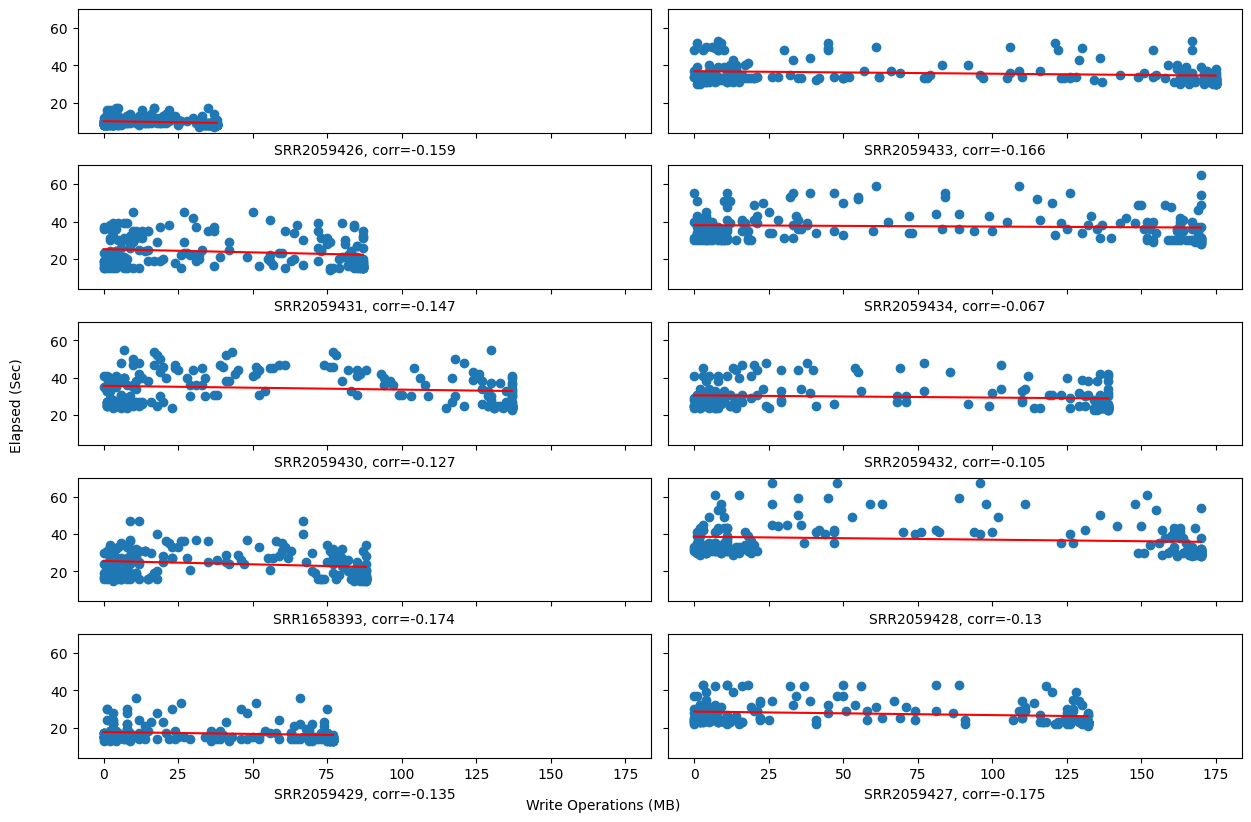

In [43]:
target = "write_bytes"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] // (1024**2)# B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
    
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Write Operations (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Read Operations (MB)')

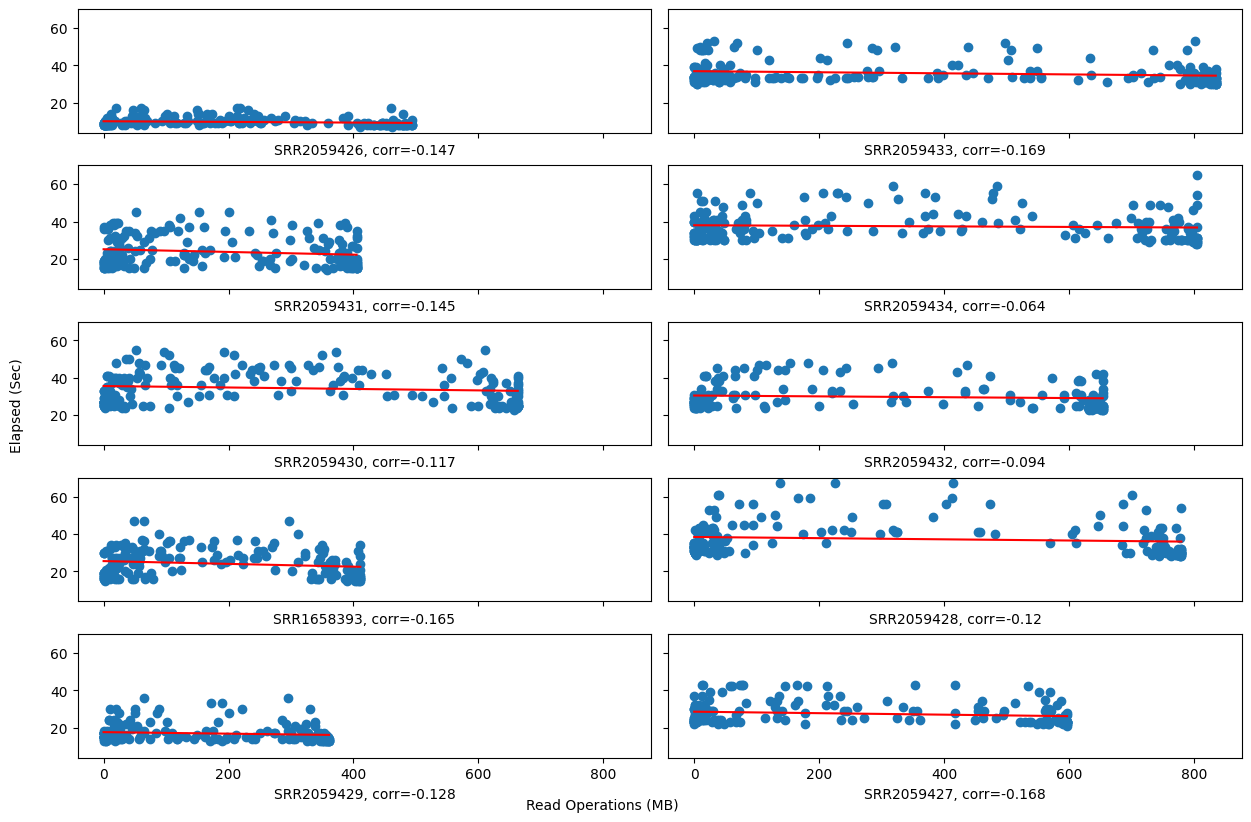

In [45]:
target = "read_bytes"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] // (1024**2)# B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
    
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Read Operations (MB)', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

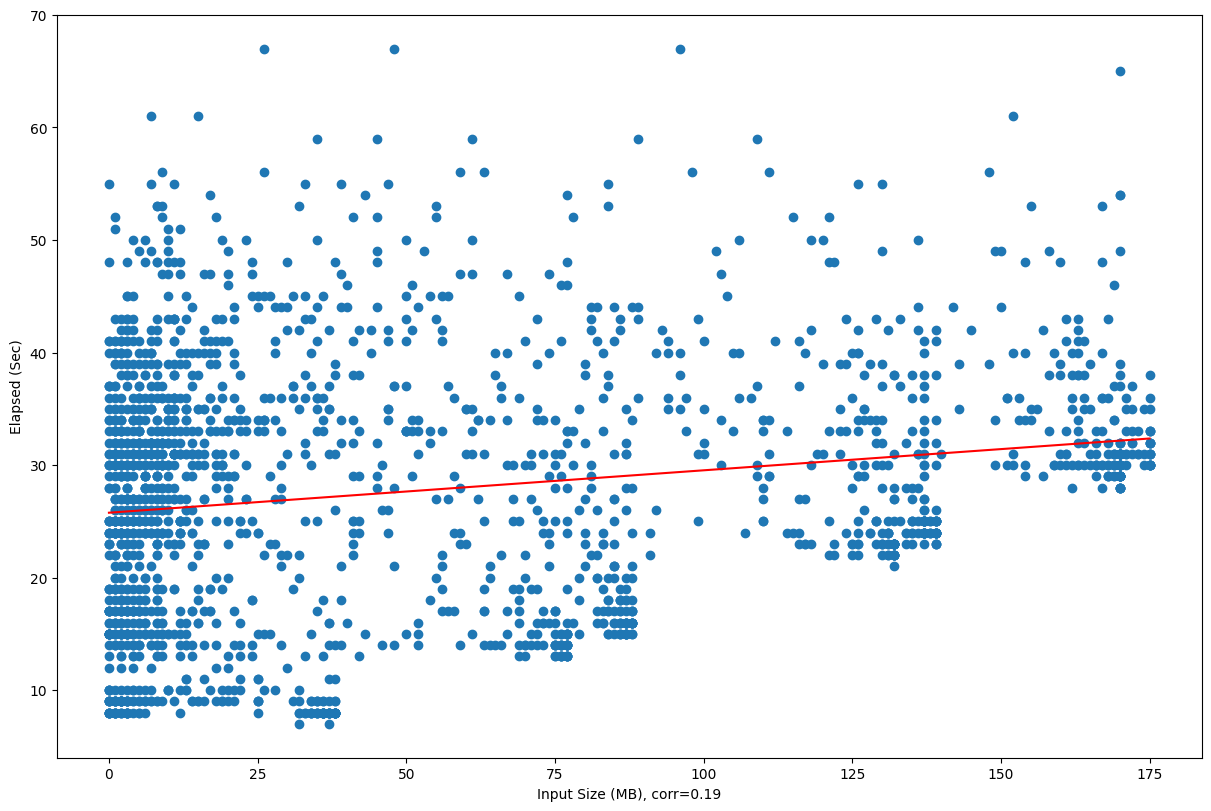

In [46]:
target = "write_bytes"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2) # B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Input Size (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

In [51]:
completed_df[completed_df["write_bytes"]==0]

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,sra_id,input_size,output_size,pid,n_pack,pack_id,ave_cpu,peak_cpu,ave_vsz,peak_vsz,ave_rss,peak_rss,read_bytes,write_bytes
78,17061,samtool.sh,2,8,55,COMPLETED,SRR2059434,842951902,179196758,238186,4,152,54.044112,101.0000,7.985889e+06,8056832,4.632740e+06,4640768,5070848,0
94,17902,samtool.sh,2,32,9,COMPLETED,SRR2059426,515558575,40870741,237351,5,510,92.884800,99.5392,8.056832e+06,8056832,4.534272e+06,4534272,0,0
100,16838,samtool.sh,8,64,48,COMPLETED,SRR2059433,874254432,183585052,162669,4,61,63.488781,101.0000,7.998535e+06,8056832,4.657152e+06,4657152,11362304,0
128,18454,samtool.sh,4,16,30,COMPLETED,SRR2059434,842951902,179196758,236083,3,747,93.875521,101.0000,8.010752e+06,8056832,4.735317e+06,4743168,4702208,0
152,18110,samtool.sh,4,8,9,COMPLETED,SRR2059426,515558575,40870741,237893,2,596,99.399233,101.0000,8.033621e+06,8056832,4.624384e+06,4624384,5820416,0
157,18357,samtool.sh,4,16,15,COMPLETED,SRR2059429,377159581,81492736,233637,2,703,86.509500,101.0000,8.001126e+06,8056832,4.845568e+06,4845568,7655424,0
200,18479,samtool.sh,4,16,30,COMPLETED,SRR1658393,430124653,92562751,250198,6,760,47.670792,101.0000,7.976487e+06,8056832,4.677632e+06,4677632,0,0
214,17154,samtool.sh,2,32,16,COMPLETED,SRR2059429,377159581,81492736,163244,3,194,88.225364,101.0000,8.044172e+06,8056832,4.812800e+06,4812800,4313088,0
216,17794,samtool.sh,8,32,19,COMPLETED,SRR2059431,423971215,91545335,235977,4,463,91.830054,101.0000,8.035407e+06,8056832,4.726784e+06,4726784,0,0
248,17215,samtool.sh,2,32,41,COMPLETED,SRR2059432,684927418,145832101,234382,4,219,57.171968,100.0000,7.970262e+06,8056832,4.943872e+06,4943872,20434944,0


Text(0, 0.5, 'Elapsed (Sec)')

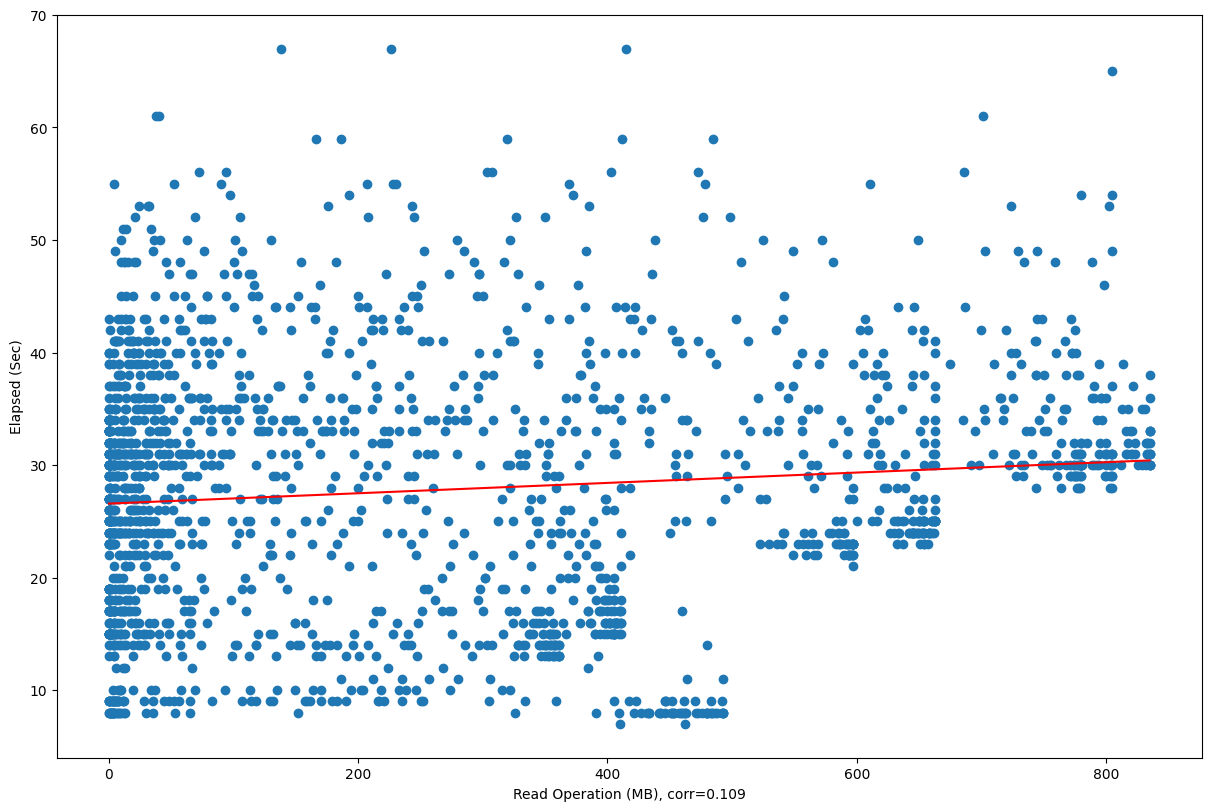

In [55]:
target = "read_bytes"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2)# B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Read Operation (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

In [50]:
completed_df[completed_df["read_bytes"]==0]

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,sra_id,input_size,output_size,pid,n_pack,pack_id,ave_cpu,peak_cpu,ave_vsz,peak_vsz,ave_rss,peak_rss,read_bytes,write_bytes
5,18480,samtool.sh,16,8,30,COMPLETED,SRR1658393,430124653,92562751,250196,6,760,47.832746,101.0000,7.976487e+06,8056832,4.952064e+06,4952064,0,2387968
48,18373,samtool.sh,8,8,26,COMPLETED,SRR2059430,694113996,144503120,237317,3,710,93.554033,101.0000,8.036937e+06,8056832,4.648960e+06,4648960,0,6291456
73,17654,samtool.sh,8,8,43,COMPLETED,SRR2059434,842951902,179196758,227302,4,405,64.836576,101.0000,8.005524e+06,8056832,4.669440e+06,4669440,0,1048576
94,17902,samtool.sh,2,32,9,COMPLETED,SRR2059426,515558575,40870741,237351,5,510,92.884800,99.5392,8.056832e+06,8056832,4.534272e+06,4534272,0,0
102,17229,samtool.sh,2,8,27,COMPLETED,SRR2059432,684927418,145832101,163635,5,226,90.738613,101.0000,8.033621e+06,8056832,4.648960e+06,4648960,0,7421952
112,17608,samtool.sh,4,8,18,COMPLETED,SRR2059431,423971215,91545335,247568,3,385,92.135842,101.0000,8.033621e+06,8056832,4.767744e+06,4767744,0,3145728
126,17601,samtool.sh,4,64,19,COMPLETED,SRR2059431,423971215,91545335,247457,4,382,73.948850,101.0000,8.022016e+06,8056832,4.706304e+06,4706304,0,1048576
138,16726,samtool.sh,16,32,23,COMPLETED,SRR2059427,625008228,138674865,237951,3,15,91.788585,101.0000,8.028979e+06,8056832,4.816896e+06,4816896,0,8388608
143,18490,samtool.sh,2,16,17,COMPLETED,SRR1658393,430124653,92562751,241546,3,763,92.458509,101.0000,8.031511e+06,8056832,4.849664e+06,4849664,0,2097152
147,17567,samtool.sh,4,64,15,COMPLETED,SRR2059429,377159581,81492736,239694,4,368,90.525191,101.0000,8.044172e+06,8056832,4.878336e+06,4878336,0,1802240


Text(0, 0.5, 'Elapsed (Sec)')

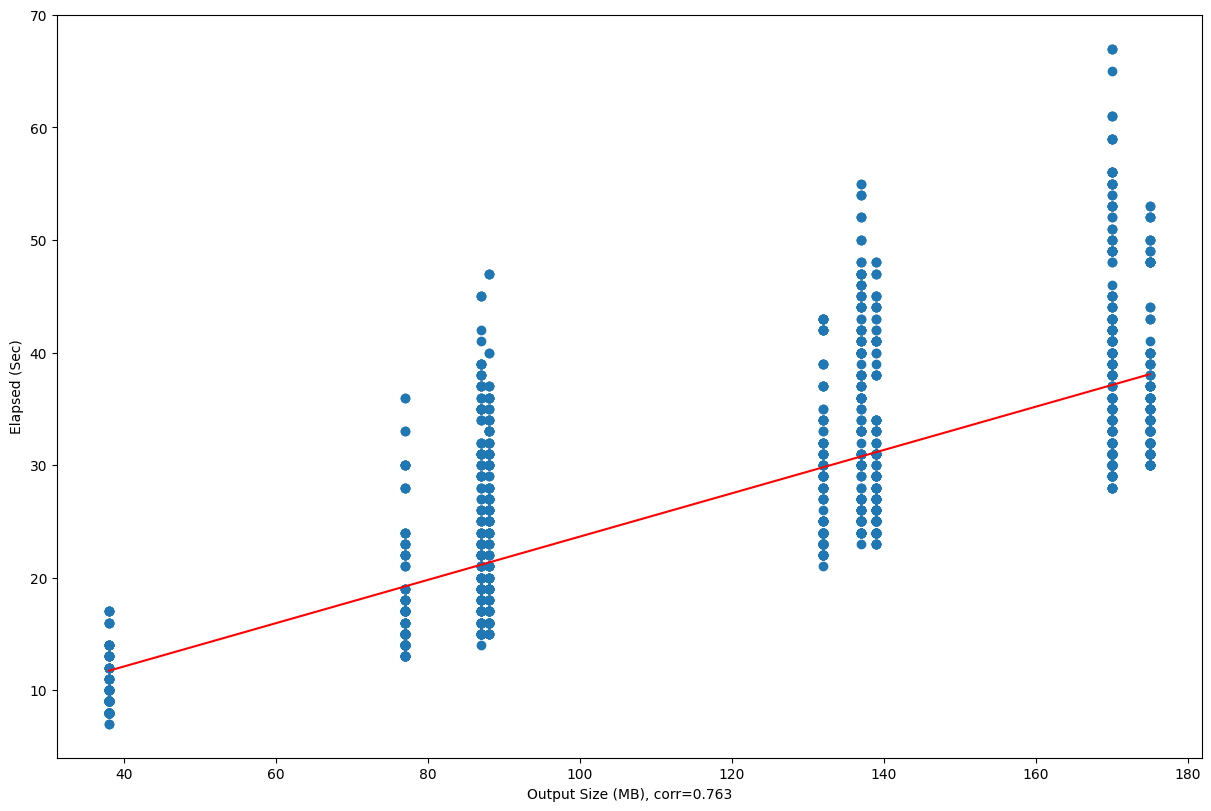

In [52]:
target = "output_size"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2)# B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Output Size (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

## MACHINE LEARNING

In [18]:
from scipy.stats.stats import pearsonr
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [19]:
def calculate_correlation(df, features, target):
    
    corr_dict = dict()
    y = df[target]
    for col in features:
        
        x = df[col]
        corr, _ =  pearsonr(x, y)
        corr_dict[col] = corr
    
  
    corr_df = pd.Series(corr_dict)
    corr_df.index = features
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda x:np.abs(x[1]), reverse=True))
    
    return sorted_corr_dict

def split_train_test(df, test_prop=0.25):
    separator_index = int(df.shape[0] * (1-test_prop))
    np.random.seed(42)
    df = df.sample(frac = 1)
    train_data, test_data = df.iloc[:separator_index], df.iloc[separator_index:]
    return train_data, test_data
    
def fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo):
    model = None
    score = -1
    
    if algo == "linear_regression":
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = metrics.mean_absolute_error(y_test, y_pred)
    if algo == "random_forest":
        model = RandomForestRegressor(n_estimators = 1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = metrics.mean_absolute_error(y_test, y_pred)
    
    
    return model, score

def get_k_of_best_model(models_dict):
    best_score = np.inf
    best_k = -1
    
    for k in models_dict:
        model = models_dict[k][0]
        score = models_dict[k][1]
        if score < best_score:
            best_score = score
            best_k = k
    return best_k


def get_best_pos_models(train_data, test_data, pre_features, pos_features, algo):
    df = pd.concat([train_data, test_data], ignore_index=False, axis=0)
    best_pos_models_dict = dict()
    for pos in pos_features:
        pos_corr_dict = calculate_correlation(df, pre_features, pos)
        sorted_pos_features = [feature for feature in pos_corr_dict]
        for i in range(len(sorted_pos_features)):
            k = i+1
            best_k_pos_features = sorted_pos_features[:k]
            
            X_train = train_data[best_k_pos_features].values
            y_train = train_data[pos].values
            X_test = test_data[best_k_pos_features].values
            y_test = test_data[pos].values
            
            model, score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)

            if pos not in best_pos_models_dict or score < best_pos_models_dict[pos][2]:
                best_pos_models_dict[pos] = [model, best_k_pos_features, score]

                
    return best_pos_models_dict

def build_two_stage(df, algo):
    
    pre_features = ['alloc_cpu', 
                    'alloc_mem_gb', 
                    'input_size',
                   'n_pack']
    
    pos_features = ['output_size', 
                'ave_cpu', 
                'peak_cpu',
                'ave_vsz',
                'peak_vsz',
                'ave_rss',
                'peak_rss',
                'read_bytes',
                'write_bytes']
    
    features = pre_features + pos_features
    

    train_data, test_data = split_train_test(df, 0.25)
    
    elapsed_corr_dict = calculate_correlation(df, features, 'elapsed_sec')
    
    # FEATURES FOR PREDICTING ELAPSED TIME
    sorted_elapsed_features = [feature for feature in elapsed_corr_dict]
    
#     pre_elapsed_features = [feature for feature in sorted_elapsed_features if feature in pre_features]
    
#     post_elapsed_features = [feature for feature in sorted_elapsed_featues if feature in post_features]
    
    best_pos_models_dict = get_best_pos_models(train_data, test_data, pre_features, pos_features, algo)
    
    elapsed_models_dict = dict()
    
    for i in range(len(sorted_elapsed_features)):
        k = i+1
        best_k_elapsed_features = sorted_elapsed_features[:k]

#         best_k_elapsed_pre_features = [feature for feature in best_k_elapsed_features if feature in pre_features]
#         best_k_elapsed_pos_features = [feature for feature in best_k_elapsed_features if feature in pos_features]
        
        for pos in pos_features:
            pos_model = best_pos_models_dict[pos][0]
            pos_pre_features = best_pos_models_dict[pos][1]
            
            X_train = train_data[pos_pre_features].values
            X_test = test_data[pos_pre_features].values
            
            train_data.loc[:, pos] = pos_model.predict(X_train)
            test_data.loc[:, pos] = pos_model.predict(X_test)
            
        
        X_train = train_data[best_k_elapsed_features].values
        y_train = train_data['elapsed_sec'].values
        X_test = test_data[best_k_elapsed_features].values
        y_test = test_data['elapsed_sec'].values
        
        elapsed_model, elapsed_score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)
        
        elapsed_models_dict[k] = [elapsed_model, elapsed_score]
        
    k_of_best_model = get_k_of_best_model(elapsed_models_dict)
    best_model = elapsed_models_dict[k_of_best_model][0]
    
    print(elapsed_models_dict)
    #return elapsed_models_dict, best_pos_models_dict, best_k_elapsed_features
    return best_model, best_pos_models_dict, sorted_elapsed_features[:k_of_best_model]

def build_single_stage(df, algo):
    pre_features = ['alloc_cpu', 
                    'alloc_mem_gb',  
                    'input_size',
                   'n_pack']
    
    pos_features = ['output_size', 
                'ave_cpu', 
                'peak_cpu',
                'ave_vsz',
                'peak_vsz',
                'ave_rss',
                'peak_rss',
                'read_bytes',
                'write_bytes']
    
    train_data, test_data = split_train_test(df, 0.25)
    
    features = pre_features + pos_features
    
    corr_dict = calculate_correlation(df, features, 'elapsed_sec')
    
    sorted_elapsed_features = [feature for feature in corr_dict if feature in pre_features]
    
    elapsed_models_dict = dict()
    
    for i in range(len(sorted_elapsed_features)):
        k = i+1
        best_k_elapsed_features = sorted_elapsed_features[:k]
        
        X_train = train_data[best_k_elapsed_features].values
        y_train = train_data['elapsed_sec'].values
        X_test = test_data[best_k_elapsed_features].values
        y_test = test_data['elapsed_sec'].values
        
        elapsed_model, elapsed_score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)
        
        elapsed_models_dict[k] = [elapsed_model, elapsed_score]
    
    k_of_best_model = get_k_of_best_model(elapsed_models_dict)
    best_model = elapsed_models_dict[k_of_best_model][0]
    
    return best_model, sorted_elapsed_features[:k_of_best_model]

In [20]:
completed_df = sum_df[sum_df["state"] == "COMPLETED"]
completed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1996 entries, 0 to 1995
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job_id        1996 non-null   int64  
 1   job_name      1996 non-null   object 
 2   alloc_cpu     1996 non-null   int64  
 3   alloc_mem_gb  1996 non-null   int64  
 4   elapsed_sec   1996 non-null   int64  
 5   state         1996 non-null   object 
 6   sra_id        1996 non-null   object 
 7   input_size    1996 non-null   int64  
 8   output_size   1996 non-null   int64  
 9   pid           1996 non-null   int64  
 10  n_pack        1996 non-null   int64  
 11  pack_id       1996 non-null   int64  
 12  ave_cpu       1996 non-null   float64
 13  peak_cpu      1996 non-null   float64
 14  ave_vsz       1996 non-null   float64
 15  peak_vsz      1996 non-null   int64  
 16  ave_rss       1996 non-null   float64
 17  peak_rss      1996 non-null   int64  
 18  read_bytes    1996 non-null 

In [21]:
lr_single_stage_elapsed_model, lr_single_stage_features = build_single_stage(completed_df, "linear_regression")

In [22]:
rf_single_stage_elapsed_model, rf_single_stage_features = build_single_stage(completed_df, "random_forest")

In [23]:
lr_second_stage_elapsed_model, lr_first_stage_models, lr_second_stage_features = build_two_stage(completed_df, 'linear_regression')

{1: [LinearRegression(), 6.750616462327309], 2: [LinearRegression(), 6.620295772541067], 3: [LinearRegression(), 6.559750396901218], 4: [LinearRegression(), 6.550473518013049], 5: [LinearRegression(), 6.550473518015178], 6: [LinearRegression(), 6.550473518015173], 7: [LinearRegression(), 6.5504735180151625], 8: [LinearRegression(), 6.550473518015188], 9: [LinearRegression(), 6.5504735180151865], 10: [LinearRegression(), 6.550473518015187], 11: [LinearRegression(), 6.550473518015189], 12: [LinearRegression(), 6.550473518015188], 13: [LinearRegression(), 6.550473518015188]}


In [24]:
rf_second_stage_elapsed_model, rf_first_stage_models, rf_second_stage_features = build_two_stage(completed_df, 'random_forest')

{1: [RandomForestRegressor(n_estimators=1000), 5.5044086247420445], 2: [RandomForestRegressor(n_estimators=1000), 5.503073552374359], 3: [RandomForestRegressor(n_estimators=1000), 5.261830987170284], 4: [RandomForestRegressor(n_estimators=1000), 5.26512965476851], 5: [RandomForestRegressor(n_estimators=1000), 5.257263531261548], 6: [RandomForestRegressor(n_estimators=1000), 5.2531899214772055], 7: [RandomForestRegressor(n_estimators=1000), 5.250935816115836], 8: [RandomForestRegressor(n_estimators=1000), 5.2558594228060596], 9: [RandomForestRegressor(n_estimators=1000), 5.252459011256392], 10: [RandomForestRegressor(n_estimators=1000), 5.253014244785753], 11: [RandomForestRegressor(n_estimators=1000), 5.253688405464103], 12: [RandomForestRegressor(n_estimators=1000), 5.851186153385282], 13: [RandomForestRegressor(n_estimators=1000), 5.812226166704987]}


In [25]:
def absolute_error(actual, calculated):
    n = len(actual)
    result = np.zeros(n)
    for i in range(n):
        result[i] = abs(actual[i]-calculated[i])
    return result

def error(actual, calculated):
    n = len(actual)
    result = np.zeros(n)
    for i in range(n):
        result[i] = calculated[i]-actual[i]
    return result
def evaluate_single_model(model, features, target, df, metrics):
    train_data, test_data = split_train_test(df, 0.25)
    X_test = test_data[features].values
    y_test = test_data[target].values
    y_pred = model.predict(X_test)
    scores = None
    if metrics == 'absolute_error':
        scores = absolute_error(y_test, y_pred)
    if metrics == 'squared_error':
        scores = squared_error(y_test, y_pred)
    if metrics == 'error':
        scores = error(y_test, y_pred)
    return scores

def evaluate_two_stage_model(first_stage_models, second_stage_model, features, target, df, metrics):
    train_data, test_data = split_train_test(df, 0.25)
    
    pos_features = ['output_size', 
                'ave_cpu', 
                'peak_cpu',
                'ave_vsz',
                'peak_vsz',
                'ave_rss',
                'peak_rss',
                'read_bytes',
                'write_bytes']

    
    for feature in features:
        if feature in pos_features:
            first_stage_model = first_stage_models[feature][0]
            pre_features = first_stage_models[feature][1]
            test_data.loc[:, feature] = first_stage_model.predict(test_data[pre_features].values)    
    
    X_test = test_data[features].values
    y_test = test_data[target].values
    
    y_pred = second_stage_model.predict(X_test)
    
    scores = None
    if metrics == 'absolute_error':
        scores = absolute_error(y_test, y_pred)
    if metrics == 'squared_error':
        scores = squared_error(y_test, y_pred)
    if metrics == 'error':
        scores = error(y_test, y_pred)
    return scores
    

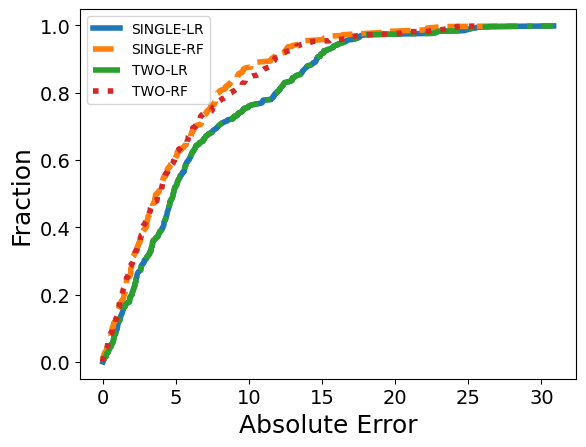

In [26]:
completed_df = sum_df[sum_df["state"] == "COMPLETED"]

lr_single_ae = evaluate_single_model(lr_single_stage_elapsed_model, lr_single_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
rf_single_ae = evaluate_single_model(rf_single_stage_elapsed_model, rf_single_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
lr_two_ae = evaluate_two_stage_model(lr_first_stage_models, lr_second_stage_elapsed_model, lr_second_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
rf_two_ae = evaluate_two_stage_model(rf_first_stage_models, rf_second_stage_elapsed_model, rf_second_stage_features, 'elapsed_sec', completed_df, 'absolute_error')


sorted_lr_single_ae = np.sort(lr_single_ae)
frac_lr_single_ae = np.arange(len(lr_single_ae)) / len(lr_single_ae)

sorted_rf_single_ae = np.sort(rf_single_ae)
frac_rf_single_ae = np.arange(len(rf_single_ae)) / len(rf_single_ae)

sorted_lr_two_ae = np.sort(lr_two_ae)
frac_lr_two_ae = np.arange(len(lr_two_ae)) / len(lr_two_ae)

sorted_rf_two_ae = np.sort(rf_two_ae)
frac_rf_two_ae = np.arange(len(rf_two_ae)) / len(rf_two_ae)

plt.plot(sorted_lr_single_ae, frac_lr_single_ae, '-', label='SINGLE-LR', linewidth=4)
plt.plot(sorted_rf_single_ae, frac_rf_single_ae, '--', label='SINGLE-RF', linewidth=4)
plt.plot(sorted_lr_two_ae, frac_lr_two_ae, '-.', label='TWO-LR', linewidth=4)
plt.plot(sorted_rf_two_ae, frac_rf_two_ae, ':', label='TWO-RF', linewidth=4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Absolute Error', fontsize=18)
plt.ylabel('Fraction', fontsize=18)
plt.legend()

# train_data, test_data = split_train_test(df, 0.25)



# # X_train = train_data[lr_single_stage_features].values
# # y_train = train_data['elapsed_sec'].values
# X_test = test_data[lr_single_stage_features].values
# y_test = test_data['elapsed_sec'].values
# y_pred = lr_single_stage_elapsed_model.predict(X_test)
# lr_single_ae = absolute_error(y_test, y_pred)

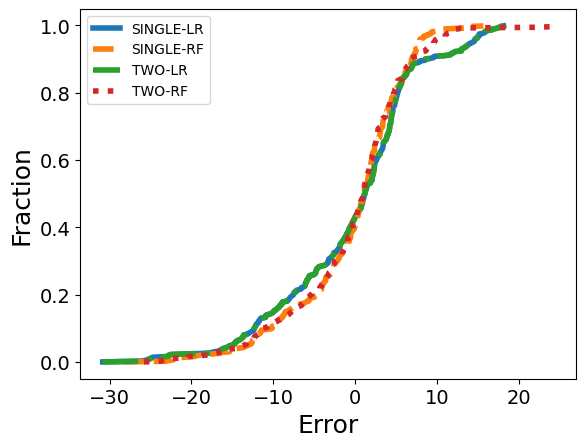

In [27]:
metrics = 'error'
completed_df = sum_df[sum_df["state"] == "COMPLETED"]

lr_single_e = evaluate_single_model(lr_single_stage_elapsed_model, lr_single_stage_features, 'elapsed_sec', completed_df, metrics)
rf_single_e = evaluate_single_model(rf_single_stage_elapsed_model, rf_single_stage_features, 'elapsed_sec', completed_df, metrics)
lr_two_e = evaluate_two_stage_model(lr_first_stage_models, lr_second_stage_elapsed_model, lr_second_stage_features, 'elapsed_sec', completed_df, metrics)
rf_two_e = evaluate_two_stage_model(rf_first_stage_models, rf_second_stage_elapsed_model, rf_second_stage_features, 'elapsed_sec', completed_df, metrics)


sorted_lr_single_e = np.sort(lr_single_e)
frac_lr_single_e = np.arange(len(lr_single_e)) / len(lr_single_e)

sorted_rf_single_e = np.sort(rf_single_e)
frac_rf_single_e = np.arange(len(rf_single_e)) / len(rf_single_e)

sorted_lr_two_e = np.sort(lr_two_e)
frac_lr_two_e = np.arange(len(lr_two_e)) / len(lr_two_e)

sorted_rf_two_e = np.sort(rf_two_e)
frac_rf_two_e = np.arange(len(rf_two_ae)) / len(rf_two_e)

plt.plot(sorted_lr_single_e, frac_lr_single_e, '-', label='SINGLE-LR', linewidth=4)
plt.plot(sorted_rf_single_e, frac_rf_single_e, '--', label='SINGLE-RF', linewidth=4)
plt.plot(sorted_lr_two_e, frac_lr_two_e, '-.', label='TWO-LR', linewidth=4)
plt.plot(sorted_rf_two_e, frac_rf_two_e, ':', label='TWO-RF', linewidth=4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Error', fontsize=18)
plt.ylabel('Fraction', fontsize=18)
plt.legend()

# train_data, test_data = split_train_test(df, 0.25)



# # X_train = train_data[lr_single_stage_features].values
# # y_train = train_data['elapsed_sec'].values
# X_test = test_data[lr_single_stage_features].values
# y_test = test_data['elapsed_sec'].values
# y_pred = lr_single_stage_elapsed_model.predict(X_test)
# lr_single_ae = absolute_error(y_test, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


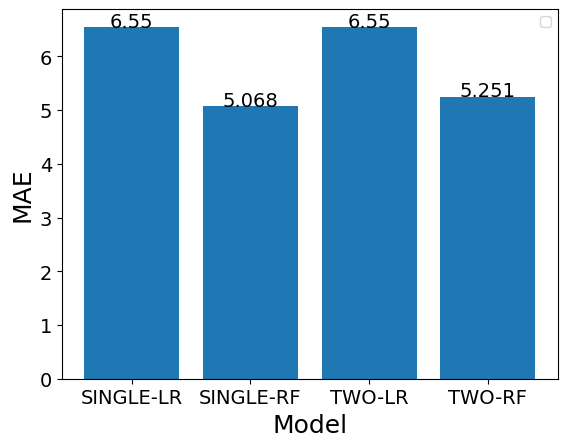

In [28]:
x = ['SINGLE-LR', 'SINGLE-RF', 'TWO-LR', 'TWO-RF']
y = [np.mean(lr_single_ae), 
     np.mean(rf_single_ae),
    np.mean(lr_two_ae),
    np.mean(rf_two_ae)]

for i in range(len(y)):
    plt.text(i, y[i], np.round(y[i],3),ha="center", fontsize=14)

plt.bar(x, y)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Model', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.legend()